<a href="https://colab.research.google.com/github/tanyatoluay/Chest-X-Ray-Images-with-Pneumothorax-Masks/blob/Julia_dev/CVfBI_Project_Julias_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('CVFBI_project_data')
#!unzip CVFBI_project_data/MyDrive/CVFBI_project_data/siim-acr-pneumothorax.zip
#!unzip CVFBI_project_data/MyDrive/CVFBI_project_data/siim-acr-pneumothorax-segmentation.zip

Drive already mounted at CVFBI_project_data; to attempt to forcibly remount, call drive.mount("CVFBI_project_data", force_remount=True).
Archive:  CVFBI_project_data/MyDrive/CVFBI_project_data/siim-acr-pneumothorax.zip
replace png_images/0_test_1_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  CVFBI_project_data/MyDrive/CVFBI_project_data/siim-acr-pneumothorax-segmentation.zip
replace download_images.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [35]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


##### weights
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.utils import class_weight

# loading images
import cv2
from tqdm import tqdm

In [13]:
# Paths to the dataset
csv_path = '/content/stage_1_test_images.csv'
mask_dir = '/content/png_masks'

# Load CSV metadata
df = pd.read_csv(csv_path)

# Add mask path and check if mask file exists
df['mask_path'] = df['new_filename'].apply(lambda x: os.path.join(mask_dir, x))
df['mask_exists'] = df['mask_path'].apply(os.path.exists)

# Function to calculate mask area
def get_mask_area(mask_path):
    if os.path.exists(mask_path):
        mask = np.array(Image.open(mask_path))
        return np.sum(mask > 0)
    else:
        return 0

# Calculate mask areas for all images
df['mask_area'] = df['mask_path'].apply(get_mask_area)

# Summary stats
total_images = len(df)
with_pneumo = df['has_pneumo'].sum()
without_pneumo = total_images - with_pneumo

print(f"Total images: {total_images}")
print(f"Images with pneumothorax (CSV label): {with_pneumo}")
print(f"Images without pneumothorax (CSV label): {without_pneumo}")

print(f"Images with mask file: {df['mask_exists'].sum()}")
print(f"Images without mask file: {total_images - df['mask_exists'].sum()}")

Total images: 1372
Images with pneumothorax (CSV label): 290
Images without pneumothorax (CSV label): 1082
Images with mask file: 1372
Images without mask file: 0


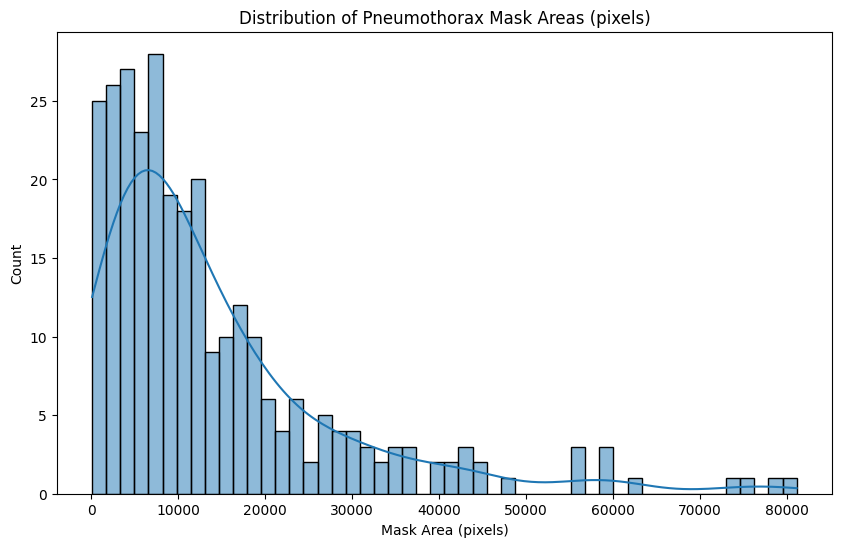

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(df[df['mask_area'] > 0]['mask_area'], bins=50, kde=True)
plt.title('Distribution of Pneumothorax Mask Areas (pixels)')
plt.xlabel('Mask Area (pixels)')
plt.ylabel('Count')
plt.show()

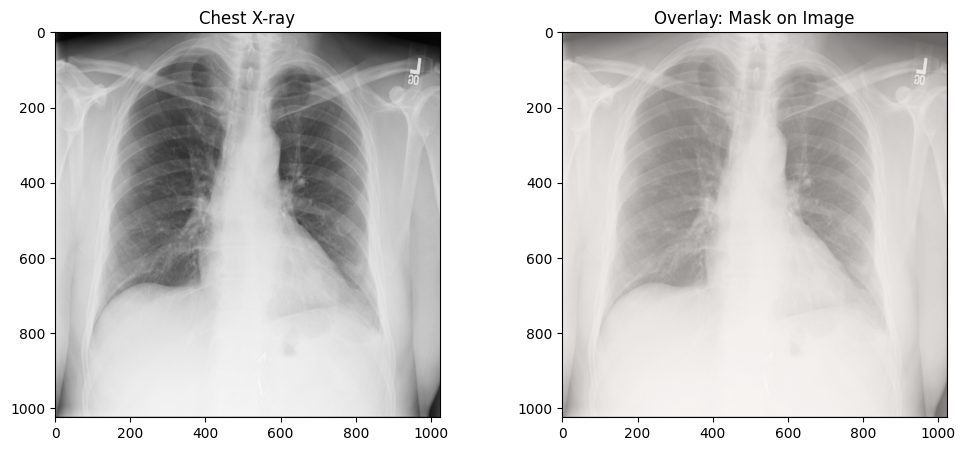

In [15]:
# Define paths
image_dir = '/content/png_images'
mask_dir = '/content/png_masks'

# List all mask files
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

# Pick the first mask file as an example
sample_mask_file = mask_files[0]

# The corresponding image file (assuming naming scheme is similar)
sample_image_file = sample_mask_file.replace('_mask', '')

# Load images
img = Image.open(os.path.join(image_dir, sample_image_file))
mask = Image.open(os.path.join(mask_dir, sample_mask_file))

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Chest X-ray')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.4)
plt.title('Overlay: Mask on Image')
plt.show()

Helper Functions
Rename link masks

In [16]:
%%writefile rename_link_masks.sh
#!/bin/bash

SOURCE_DIR="$1"

if [[ -z "$SOURCE_DIR" || ! -d "$SOURCE_DIR" ]]; then
  echo "Usage: $0 /path/to/source_dir"
  exit 1
fi

mkdir -p labelsTr labelsTs

for FILE in "$SOURCE_DIR"/*.png; do
  BASENAME=$(basename "$FILE")

  if [[ "$BASENAME" == *_train_* ]]; then
    DEST="labelsTr"
  elif [[ "$BASENAME" == *_test_* ]]; then
    DEST="labelsTs"
  else
    continue
  fi

  NEW_NAME="${BASENAME%.png}.png"

  ln -s "$(realpath "$FILE")" "$DEST/$NEW_NAME"
done

echo "Symbolic links created in labelsTr and labelsTs."

Writing rename_link_masks.sh


In [17]:
!bash rename_link_masks.sh /content/png_masks

Symbolic links created in labelsTr and labelsTs.


Rename link


In [18]:
%%writefile rename_link.sh
#!/bin/bash

SOURCE_DIR="$1"

if [[ -z "$SOURCE_DIR" || ! -d "$SOURCE_DIR" ]]; then
  echo "Usage: $0 /path/to/source_dir"
  exit 1
fi

mkdir -p imagesTr imagesTs

for FILE in "$SOURCE_DIR"/*.png; do
  BASENAME=$(basename "$FILE")

  if [[ "$BASENAME" == *_train_* ]]; then
    DEST="imagesTr"
  elif [[ "$BASENAME" == *_test_* ]]; then
    DEST="imagesTs"
  else
    continue
  fi

  NEW_NAME="${BASENAME%.png}_0000.png"

  ln -s "$(realpath "$FILE")" "$DEST/$NEW_NAME"
done

echo "Symbolic links created in imagesTr and imagesTs."

Writing rename_link.sh


In [19]:
!bash rename_link.sh /content/png_images

Symbolic links created in imagesTr and imagesTs.


Convert masks

In [20]:
%%writefile convert_masks.sh
#!/bin/bash

INPUT_DIR="$1"
OUTPUT_DIR="$2"

if [[ -z "$INPUT_DIR" || -z "$OUTPUT_DIR" ]]; then
  echo "Usage: $0 /path/to/input_dir /path/to/output_dir"
  exit 1
fi

mkdir -p "$OUTPUT_DIR"

for FILE in "$INPUT_DIR"/*.png; do
  BASENAME=$(basename "$FILE")
  OUTPUT_FILE="$OUTPUT_DIR/$BASENAME"

  convert "$FILE" -depth 8 -type Grayscale \
    -fx 'i==255 ? 1 : 0' "$OUTPUT_FILE"
done

echo "Conversion complete. Output saved in $OUTPUT_DIR."

!bash convert_masks.sh labelsTr labelsTr_converted

Writing convert_masks.sh


In [21]:
import os
from PIL import Image
import numpy as np

input_dir = 'labelsTr'           # folder with original masks (created by your rename_link_masks.sh)
output_dir = 'labelsTr_converted'  # output folder for converted masks

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith('.png'):
        mask_path = os.path.join(input_dir, filename)
        mask = Image.open(mask_path).convert('L')  # convert to grayscale

        mask_np = np.array(mask)
        # Convert 255 -> 1, keep 0 -> 0
        mask_np = (mask_np == 255).astype(np.uint8)

        out_path = os.path.join(output_dir, filename)
        Image.fromarray(mask_np).save(out_path)

print("Mask conversion done!")

Mask conversion done!


--------------------------------------------- weights

In [22]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [49]:
def load_image(image_dir, image_size):
    img_train = [] # images or masks
    label_train = []

    # print(image_dir)
    # print(os.listdir(image_dir))
    # data = data.reset_index(drop=True)
    ## Load images
    # img = Image.open(os.path.join(image_dir, sample_image_file))
    # mask = Image.open(os.path.join(mask_dir, sample_mask_file))
    for i in os.listdir(image_dir): # tqdm():
      # print(i)
      img = cv2.imread(os.path.join(image_dir,i))
      img = cv2.resize(img,(image_size, image_size))
      #mask = cv2.imread(os.path.join(image_dir,i))
      #mask = cv2.resize(mask,(image_size, image_size))
      img_train.append(img)
      # split image name to get label
      lab = i.split("_")[2]
      # print(lab)
      #mask_train.append(mask)
      label_train.append(lab)
    print("finished reding in images!")
    print("Images: " + str(len(img_train)))
    print("Labels: " + str(len(label_train)))
    return img_train, label_train


   #input_image = datapoint["image"]
   #input_mask = datapoint["segmentation_mask"]
   #input_image, input_mask = resize(input_image, input_mask)


  # return input_image, input_mask

#def load_image_test(datapoint):
  # input_image = datapoint["image"]
  # input_mask = datapoint["segmentation_mask"]

  # return input_image, input_mask

In [50]:
images_dir = '/content/imagesTr/'
masks_dir = '/content/labelsTr_converted/'

# csv_path = '/content/stage_1_test_images.csv'

# Load CSV metadata
# df = pd.read_csv(csv_path)

# list of only training images
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])

# list of only training masks
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])



train_images, train_labels = load_image(images_dir, 128)
train_masks, mask_labels = load_image(masks_dir, 128)

finished reding in images!
Images: 10675
Labels: 10675
finished reding in images!
Images: 10675
Labels: 10675


In [57]:
if not list(set(train_labels)-set(mask_labels)):
  print("Labels match!")
  labels = np.array(train_labels, dtype='int')

Labels match!


In [62]:
from collections import Counter
c = Counter(labels.flatten())
print("Class distribution:", c)

Class distribution: Counter({np.int64(0): 8296, np.int64(1): 2379})


In [66]:
# refernece: https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels.flatten()),
    y=labels.flatten()
)

# class dictionary
weights_dict = dict(enumerate(weights))
print("Class weights:", weights_dict)

Class weights: {0: np.float64(0.6433823529411765), 1: np.float64(2.2435897435897436)}


In [63]:


# example CNN:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Adjust '10' to the number of classes in your dataset
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:

# Compile the model with weighted loss
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train the model with class weights
model.fit(train_images, labels, epochs=10, batch_size=64, class_weight=weights_dict)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126
'y' sizes: 10675
'sample_weight' sizes: 10675


In [ ]:
##### U-net
